In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom as dicom
import cv2
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [2]:
import os
import pathlib
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
import tensorflow

In [5]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Pre-Processing, Data Visualization, EDA

### Exploring the given Data files, classes and images of different classes

In [6]:
df1 = pd.read_csv("rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")

In [7]:
df2 = pd.read_csv("rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

Looking at df1:

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [9]:
df1.drop_duplicates().shape

(26684, 2)

df1 has 2 classes with no null values.

In [10]:
df1.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [11]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [12]:
print("number of unique patient ids is", len(np.unique(df1.patientId.values)))

number of unique patient ids is 26684


Looking at df2:

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [14]:
df2.drop_duplicates().shape

(30227, 6)

There are many null values for the box data in df2.

In [15]:
df2.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [16]:
df = df2[df2['Target'] == 1]

In [17]:
df.shape

(9555, 6)

In [18]:
np.any(df.isna())

False

In [19]:
counts = df2['patientId'].value_counts(ascending = False)

In [20]:
counts[0:10]

ee820aa5-4804-4984-97b3-f0a71d69702f    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
Name: patientId, dtype: int64

The maximum number of bounding boxes in a scan from the dataset is 4.

In [21]:
len(counts)

26684

This shows that all null values are asspciated with target not found i.e, "Normal" and "No Lung Opacity/ Not normal" classes. 

In [22]:
np.all(df1.patientId.values == df2.patientId.values)

True

This shows that patientIds are same in both datasets and in the same order.

In [23]:
#take a patient id tagged normal
p1 = df1[df1['class'] == 'Normal'].index #consider all patients tagged 'Normal'
p1 = p1[0] #choose any patient index
p1 = df1.loc[p1, 'patientId']

In [24]:
p1

'003d8fa0-6bf1-40ed-b54c-ac657f8495c5'

In [25]:
#take a patient id tagged no lung opacity/ not normal
p2 = df1[df1['class'] == 'No Lung Opacity / Not Normal'].index #consider all patients tagged 'Normal'
p2 = p2[0] #choose any patient index
p2 = df1.loc[p2, 'patientId']

In [26]:
p2

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

look up data on both patients:

In [6]:
train_path = "C:\\Users\\Aalap\\Documents\\Local GL\\Capstone\\rsna-pneumonia-detection-challenge\\stage_2_train_images\\"

test_path = "C:\\Users\\Aalap\\Documents\\Local GL\\Capstone\\rsna-pneumonia-detection-challenge\\stage_2_test_images\\"

Patients p1 and p2 are in train folder. Compare their data.

In [28]:
info_p1 = dicom.dcmread(train_path + p1 + '.dcm')
info_p2 = dicom.dcmread(train_path + p2 + '.dcm')

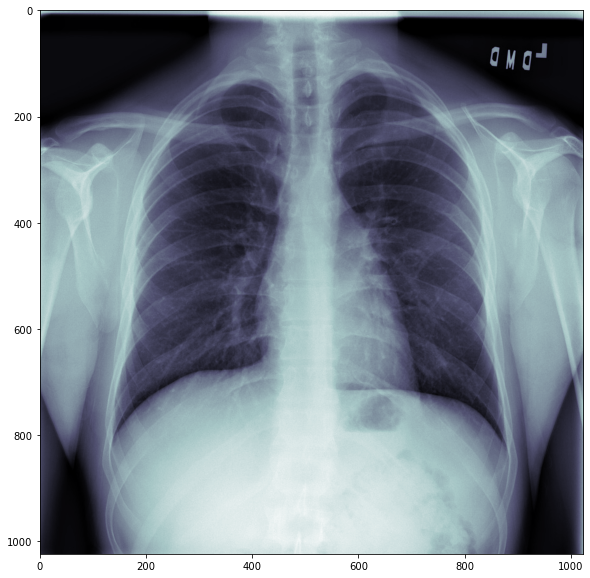

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(info_p1.pixel_array, cmap = plt.cm.bone) #normal patient

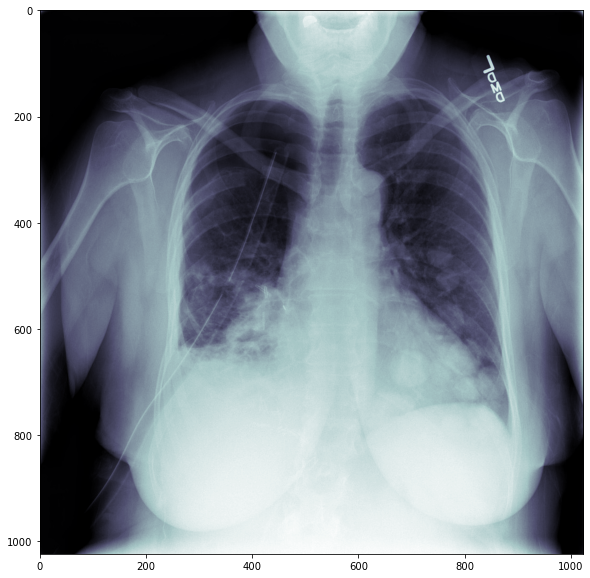

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(info_p2.pixel_array, cmap = plt.cm.bone) #no lung opacity / not normal patient

In [31]:
info_p1

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [32]:
info_p2

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Since other than the visual data itself no information in provided to discriminate between normal patients from no lung opacity but not normal patients, it is best to consider only binary classification of patients, either normal or not normal.

Combining all data for EDA:

In [33]:
df2.shape

(30227, 6)

In [34]:
df2[df2['Target'] == 1].shape

(9555, 6)

In [35]:
ages = []
gender = []
modality = []
view_position = []
for p in df2['patientId'].values:
    info = dicom.dcmread(train_path + p + '.dcm')
    ages.append(info.PatientAge)
    gender.append(info.PatientSex)
    modality.append(info.Modality)
    view_position.append(info.ViewPosition)

In [36]:
df2['ages'] = pd.Series(np.array(ages))
df2['gender'] = pd.Series(np.array(gender))
df2['modality'] = pd.Series(np.array(modality))
df2['view_position'] = pd.Series(np.array(view_position))

In [37]:
df2.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'ages', 'gender',
       'modality', 'view_position'],
      dtype='object')

In [38]:
df2.shape

(30227, 10)

In [39]:
df2[df2['Target'] == 1].shape

(9555, 10)

In [40]:
df1.shape

(30227, 2)

In [41]:
df1[df1['class'] == 'Lung Opacity'].shape

(9555, 2)

In [42]:
df2 = df2.merge(df1, on = 'patientId')

In [43]:
df2['ages'] = df2['ages'].astype('int64')

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patientId      37629 non-null  object 
 1   x              16957 non-null  float64
 2   y              16957 non-null  float64
 3   width          16957 non-null  float64
 4   height         16957 non-null  float64
 5   Target         37629 non-null  int64  
 6   ages           37629 non-null  int64  
 7   gender         37629 non-null  object 
 8   modality       37629 non-null  object 
 9   view_position  37629 non-null  object 
 10  class          37629 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 3.4+ MB


In [45]:
df2.drop_duplicates(inplace = True)

In [46]:
df2.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   ages gender modality view_position                         class  
0    51      F       CR            PA  No Lung Opacity / Not Normal  
1    48      F       CR            PA  No Lung Opacity / Not Normal  
2    19      M       CR            AP  No Lung Opacity / Not Normal  
3    28      M       CR            PA                        Normal  
4    32      F       CR            AP                  Lung Opacity

In [47]:
df2[df2['class'] == 'Lung Opacity'].shape

(9555, 11)

In [48]:
df2[df2['Target'] == 1].shape

(9555, 11)

<b><u>Univariate:</u></b>

<u>ages</u>

In [49]:
df2['ages'].describe()

count    30227.000000
mean        46.797764
std         16.892940
min          1.000000
25%         34.000000
50%         49.000000
75%         59.000000
max        155.000000
Name: ages, dtype: float64

Mean age of patients is 46 years. Least age is 1 year and Oldest ages is 155 years.

In [50]:
iqr = df2['ages'].describe()['75%'] - df2['ages'].describe()['25%']
upper = df2['ages'].describe()['75%'] + (1.5*iqr)
lower = df2['ages'].describe()['25%'] - (1.5*iqr)
print(lower, upper)

-3.5 96.5


Upper age outliers exit.

In [51]:
df2[df2['ages'] >= upper]

patientId   x   y  width  height  Target  \
5525   3b8b8777-a1f6-4384-872a-28b95f59bf0d NaN NaN    NaN     NaN       0   
13818  73aeea88-fc48-4030-8564-0a9d7fdecac4 NaN NaN    NaN     NaN       0   
21301  a4e8e96d-93a6-4251-b617-91382e610fab NaN NaN    NaN     NaN       0   
32970  ec3697bd-184e-44ba-9688-ff8d5fbf9bbc NaN NaN    NaN     NaN       0   
34436  f632328d-5819-4b29-b54f-adf4934bbee6 NaN NaN    NaN     NaN       0   

       ages gender modality view_position                         class  
5525    148      M       CR            PA                        Normal  
13818   151      F       CR            PA  No Lung Opacity / Not Normal  
21301   153      M       CR            PA  No Lung Opacity / Not Normal  
32970   150      M       CR            PA                        Normal  
34436   155      F       CR            PA                        Normal

In [52]:
print("There are", df2[df2['ages'] >= upper].shape[0], "upper outliers to age.")

There are 5 upper outliers to age.


None of the 5 patients belonged to the pneumonia category. Gender of patients is also almost equally split.

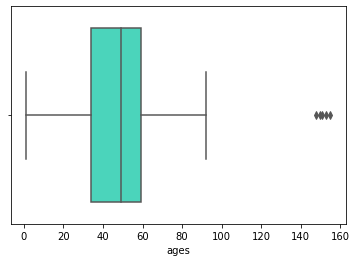

In [53]:
sns.boxplot(x = df2['ages'], color = '#34ebc9');

The shape of age distribution roughly symmetric.

In [54]:
temp = df2[df2['ages'] < upper]

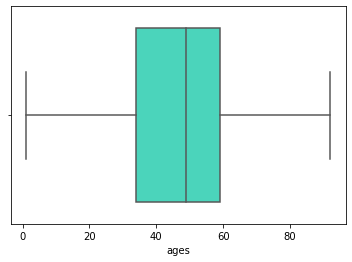

In [55]:
sns.boxplot(x = temp['ages'], color = '#34ebc9');

Without outliers, the distribution looks slightly left skewed.

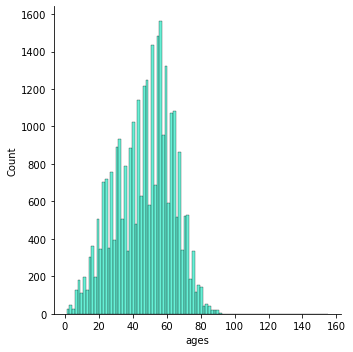

In [56]:
sns.displot(x = df2['ages'], color = '#34ebc9');

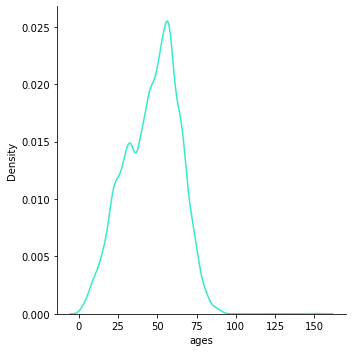

In [57]:
sns.displot(x = df2['ages'], color = '#34ebc9', kind = 'kde');

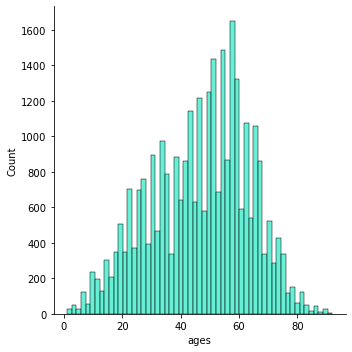

In [58]:
sns.displot(x = temp['ages'], color = '#34ebc9');

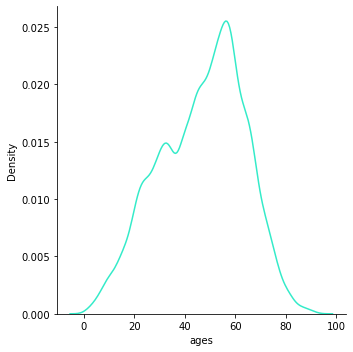

In [59]:
sns.displot(x = temp['ages'], color = '#34ebc9', kind = 'kde');

<u>gender:</u>

In [60]:
df2['gender'].value_counts()

M    17216
F    13011
Name: gender, dtype: int64

In [61]:
df2['gender'].value_counts(normalize = True)

M    0.569557
F    0.430443
Name: gender, dtype: float64

Most patients are male. Almost 57%.

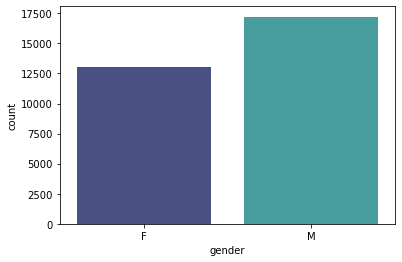

In [62]:
sns.countplot(x = df2['gender'], palette = 'mako');

<u>class</u>

In [63]:
df2['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [64]:
df2['class'].value_counts(normalize = True)

No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64

Most patients in the dataset, almost 39%, have no lung opacity on their chest radiograph but are not normal. 

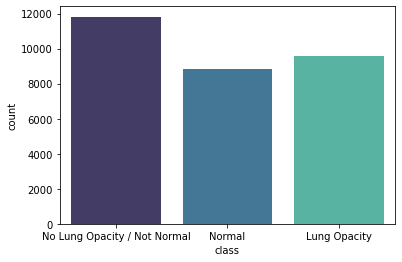

In [65]:
sns.countplot(x = df2['class'], palette = 'mako');

<u>Target</u>

In [66]:
df2['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [67]:
df2['Target'].value_counts(normalize = True)

0    0.683892
1    0.316108
Name: Target, dtype: float64

"Normal" and "No Lung Opacity / Not Normal" classes combined constitute more patients than those of "Lung Opacity" class.

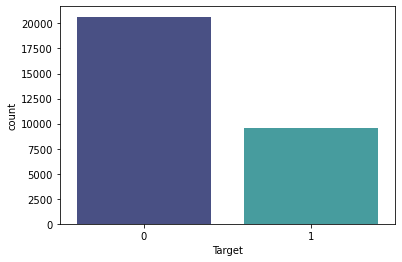

In [68]:
sns.countplot(x = df2['Target'], palette = 'mako');

<u>modality</u>

In [69]:
df2['modality'].value_counts(normalize = True)

CR    1.0
Name: modality, dtype: float64

<u>view_position</u>

In [70]:
df2['view_position'].value_counts(normalize = True)

AP    0.506071
PA    0.493929
Name: view_position, dtype: float64

PA : Posteroanteorior View (front side)<br>
AP : Anteroposterior View (back side)

<AxesSubplot:xlabel='view_position', ylabel='count'>

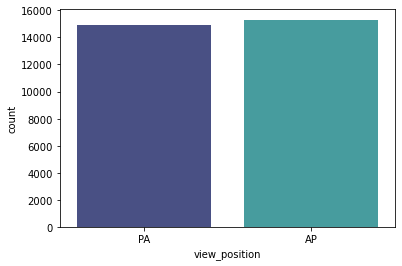

In [71]:
sns.countplot(x = df2['view_position'], palette = 'mako')

Most CXR in the dataset are if type AP.

<b><u>Bivariate</u></b>

<u>Age and Target</u>

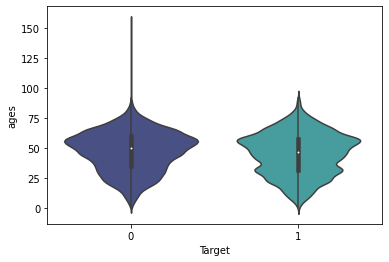

In [72]:
sns.violinplot(y = df2['ages'], x = df2['Target'], palette = 'mako'); #with outliers

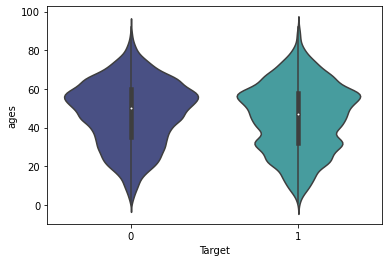

In [73]:
sns.violinplot(y = temp['ages'], x = df2['Target'], palette = 'mako'); 

Age distribution without outliers is similar for patients with pneumonia and not pneumonia.

<u>Gender and Target</u>

In [74]:
pd.crosstab(df2['Target'], df2['gender'], normalize = True, margins = True)

gender         F         M       All
Target                              
0       0.298276  0.385616  0.683892
1       0.132167  0.183942  0.316108
All     0.430443  0.569557  1.000000

of the patients tagged as 0, most are male. Of the patients tagged as 1, most are male too.

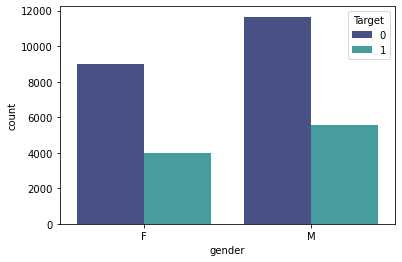

In [75]:
sns.countplot(x = df2['gender'], hue = df2['Target'], palette = 'mako');

<u>class and Target</u>

In [76]:
pd.crosstab(df2['Target'], df2['class'], normalize = True, margins = True)

class   Lung Opacity  No Lung Opacity / Not Normal    Normal       All
Target                                                                
0           0.000000                      0.391074  0.292818  0.683892
1           0.316108                      0.000000  0.000000  0.316108
All         0.316108                      0.391074  0.292818  1.000000

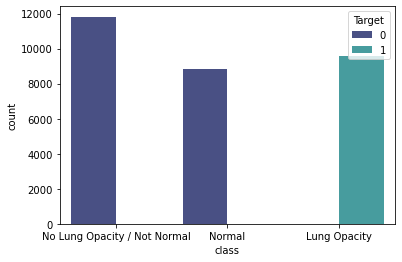

In [77]:
sns.countplot(x = df2['class'], hue = df2['Target'], palette = 'mako');

<u>view_position and Target</u>

In [78]:
pd.crosstab(df2['Target'], df2['view_position'], normalize = True, margins = True)

view_position        AP        PA       All
Target                                     
0              0.248420  0.435472  0.683892
1              0.257650  0.058458  0.316108
All            0.506071  0.493929  1.000000

Of the patients tagged as 0, most have a CXR with PA view. Of the patients tagged as 1, most have a CXR with a AP view.

<b><u>Multivariate</u></b>

<u>Target, ages and gender</u>

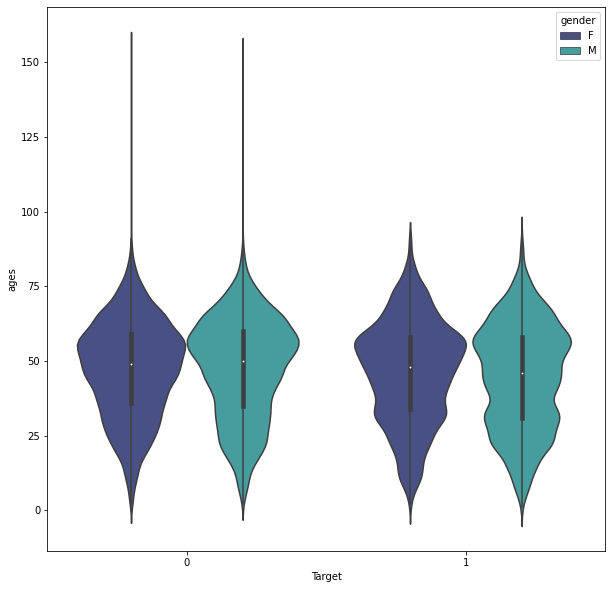

In [79]:
plt.figure(figsize=(10,10))
sns.violinplot(x = df2['Target'], y = df2['ages'], hue = df2['gender'], palette = 'mako');

Target wise distributions of age and gender are very similar.

<u>Target, ages and class</u>

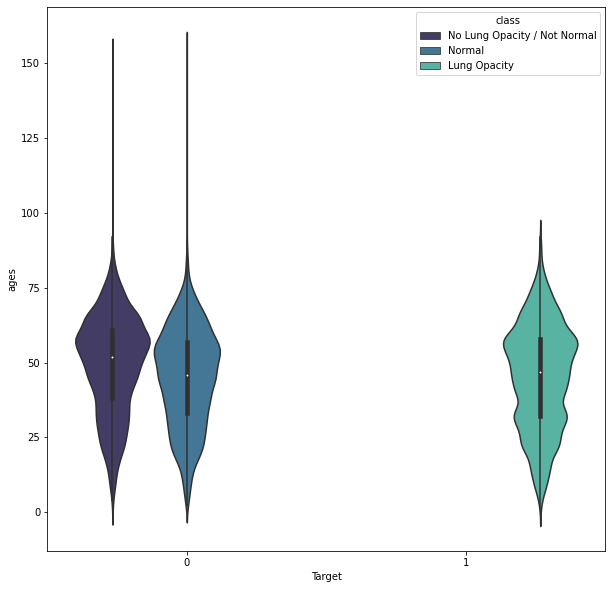

In [80]:
plt.figure(figsize=(10,10))
sns.violinplot(x = df2['Target'], y = df2['ages'], hue = df2['class'], palette = 'mako');

<u>Target, ages and view_position</u>

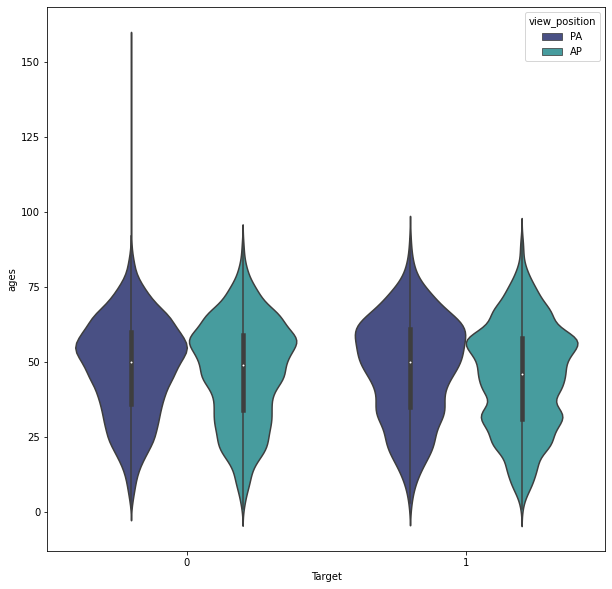

In [81]:
plt.figure(figsize=(10,10))
sns.violinplot(x = df2['Target'], y = df2['ages'], hue = df2['view_position'], palette = 'mako');

All the patients in age outliers have a CXR with PA view. <br> (PA,age) distribution is much smoother than (AP,age) distribution.

### Visualizing boxes

In [82]:
df2.shape

(30227, 11)

In [8]:
train_patients_names = df2.patientId.unique()

In [84]:
len(train_patients_names)

26684

In [ ]:
boxes = dict()

for name in train_patients_names:
    box = []
    temp = df2[df2['patientId'] == name]
    temp.reset_index(drop = True, inplace = True)
    if(temp.loc[0,'Target'] == 1): #a patient either has pneumonia or not. If no pneumonia, no bboxes so empty [].
        num_of_boxes = temp.shape[0]
        for i in range(num_of_boxes):
            x = temp.loc[i, 'x']
            y = temp.loc[i, 'y']
            w = temp.loc[i, 'width']
            h = temp.loc[i, 'height']
            box.append([x,y,w,h])
    boxes.update({name:box})
            

In [86]:
len(boxes)

26684

In [10]:
def plot_boxes(name):
    img = dicom.dcmread(train_path + name + '.dcm').pixel_array
    fig, ax = plt.subplots(figsize = (10,10))
    
    ax.imshow(img, cmap = plt.cm.bone)

    num_of_boxes = len(boxes[name])
    for i in range(num_of_boxes):
        t = boxes[name][i]
        rect = Rectangle((t[0], t[1]), t[2], t[3], linewidth = 5, color = 'r', fill = False)
        ax.add_patch(rect)

    plt.show()


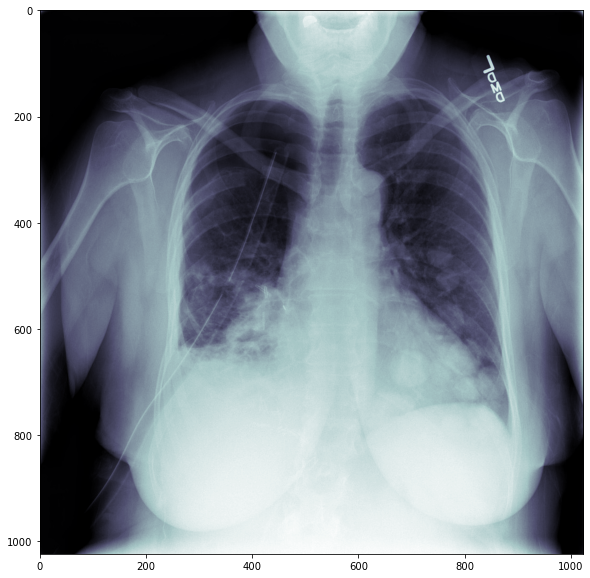

In [88]:
plot_boxes(train_patients_names[0])

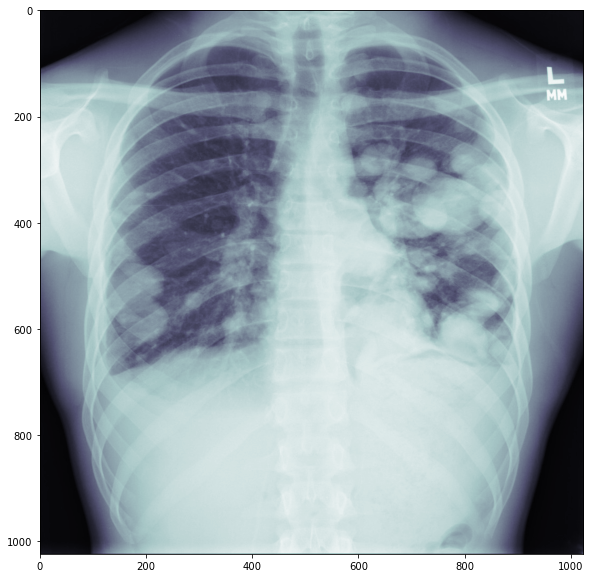

In [89]:
plot_boxes(train_patients_names[2])

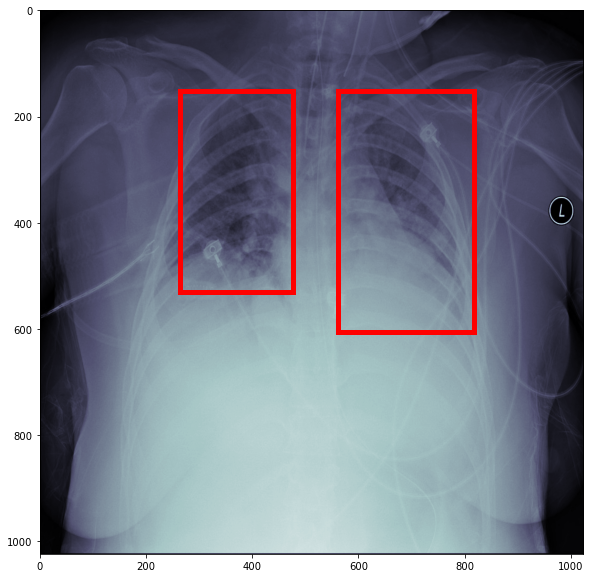

In [90]:
plot_boxes(train_patients_names[4])

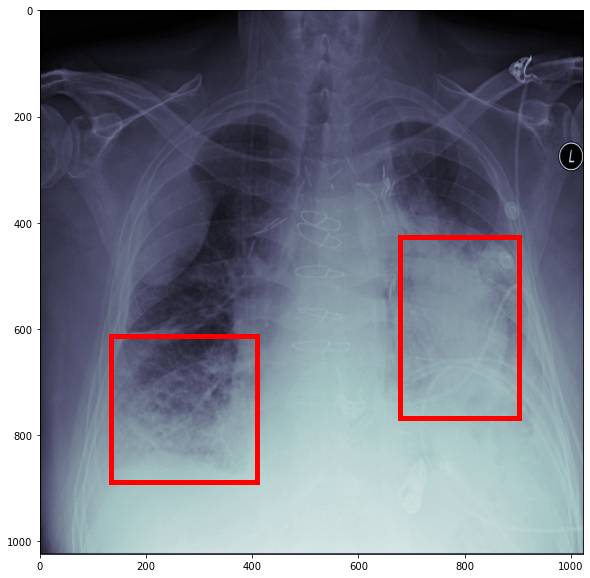

In [91]:
plot_boxes(train_patients_names[21])

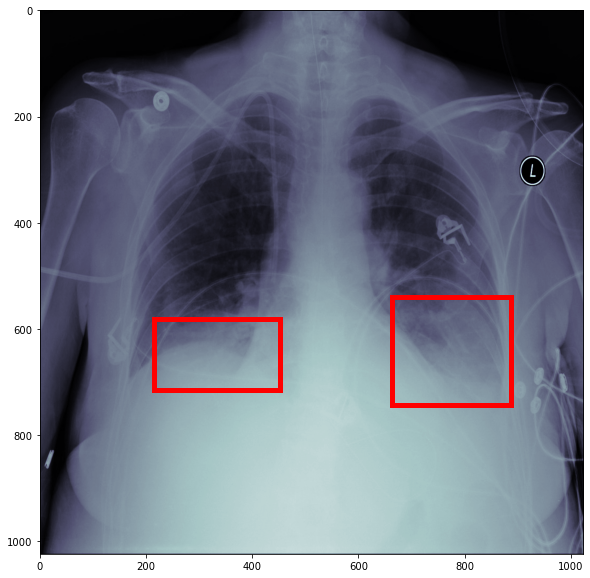

In [92]:
plot_boxes(train_patients_names[33])

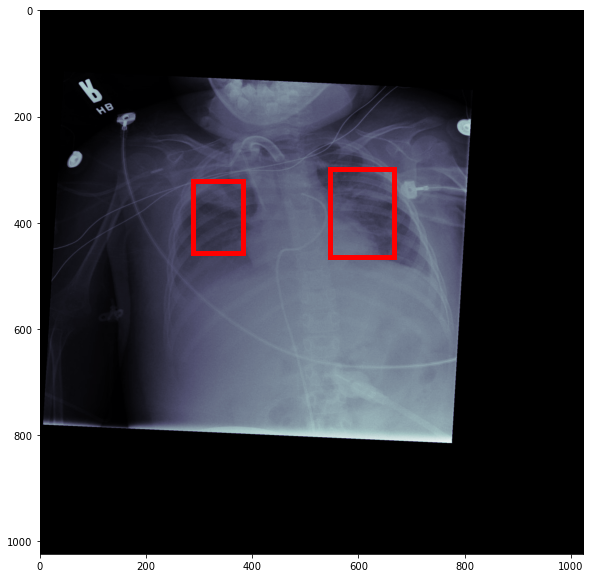

In [93]:
plot_boxes(train_patients_names[12])

## Model Building

The model will only consider images with lung opacity.

In [94]:
df2.dropna(inplace = True)

In [95]:
df2.drop(['ages', 'gender', 'class', 'Target', 'modality', 'view_position'], axis = 1, inplace = True)

In [7]:
#saving this for later

#df2.to_csv("df2", index = False)
#df2 = pd.read_csv("df2")

In [8]:
df2.shape

(9555, 5)

Goal is to train 3 different sort of models that differ by the image size used. Sizes to be used are 320x320, 512x512, 640x640.

In [20]:
def resize_df(df, size):
    df['x'] = df['x'].apply(lambda x : int(size*x/1024))
    df['y'] = df['y'].apply(lambda x : int(size*x/1024))
    df['width'] = df['width'].apply(lambda x : int(size*x/1024))
    df['height'] = df['height'].apply(lambda x : int(size*x/1024))
    return df
    

Strategy: first split data and resize y part of the data as needed. 

In [10]:
X = df2['patientId']
y = df2.drop(['patientId'], axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7644,), (1911,), (7644, 4), (1911, 4))

In [13]:
final_check_images = X_train[-5:]
X_train = X_train[:-5]

In [14]:
final_check_bboxes = y_train[-5:]
y_train = y_train[:-5]

In [15]:
final_check_images

2895    5a8e51d4-1b33-45b3-8f96-5a4027462cbc
7813    d01efc31-f83e-46dd-a3a1-1eb73f60ddcc
905     261341d3-1df2-4cf4-b9a8-b1e02a124900
5192    a3558c74-f838-4da4-a8be-ad248ad502cf
235     0851431b-cad7-436f-acb8-06aed97e5339
Name: patientId, dtype: object

In [16]:
final_check_bboxes

x      y  width  height
2895  124.0  258.0  183.0   457.0
7813  522.0  156.0  249.0   405.0
905   594.0  362.0  123.0   167.0
5192  588.0  494.0  184.0   282.0
235    55.0   95.0  304.0   677.0

Resizing and saving data by images size.

For 320x230 models:

In [26]:
size = 320

In [18]:
#scale all y data
temp_y_train = resize_df(y_train, size)
temp_y_test = resize_df(y_test, size)
#no need to resize final check image coordinates

In [21]:
for n in X_train.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\train\\' + n + '.jpg', img)

In [22]:
for n in X_test.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\test\\' + n + '.jpg', img)

In [23]:
for n in final_check_images.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\final_check\\' + n + '.jpg', img)

XML format with labelImg.py is: <br>
<ol>
    <li>annotations <ol>
        <li>folder</li>
        <li>filename</li>
        <li>path</li>
        <li>source<ul><li>database</li></ul></li> 
        <li>size <ul><li>width</li><li>height</li><li>depth</li></ul> </li>
        <li>segmented</li>
        <li>object <ul><li>name</li><li>pose</li><li>truncated</li><li>difficult</li><li>bndbox <ul><li>xmin</li><li>ymin</li><li>xmax</li><li>ymax</li></ul> </li></ul> </li>
        </ol></li>
</ol>

In [33]:
def generate_xml(n, dest):
    
    annot = ET.Element('annotation')
    
    folder = ET.SubElement(annot, 'folder')
    folder.text = dest
    
    filename = ET.SubElement(annot, 'filename')
    filename.text = n + '.jpg'
    
    path = ET.SubElement(annot, 'path')
    path.text = 'C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.jpg'
    
    source = ET.SubElement(annot, 'source')
    database = ET.SubElement(source, 'database')
    database.text = 'Unknown'
    
    size = ET.SubElement(annot, 'size')
    width = ET.SubElement(size, 'width')
    width.text = '320'
    height = ET.SubElement(size, 'height')
    height.text = '320'
    depth = ET.SubElement(size, 'depth')
    depth.text = '1'
    
    segmented = ET.SubElement(annot, 'segmented')
    segmented.text = '0'
    
    temp = df2[df2['patientId'] == n]
    temp.reset_index(drop = True, inplace = True)
    temp = resize_df(temp, 320)
    
    num_of_boxes = temp.shape[0]
    
    for i in range(num_of_boxes):
        obj = ET.SubElement(annot, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = '1'
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'
        bndbox = ET.SubElement(obj, 'bndbox')
        
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text= str(temp.loc[i, 'x'])
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(temp.loc[i, 'y'])
        xmax = ET.SubElement(bndbox, 'xmax')
        x2 = temp.loc[i, 'x'] + temp.loc[i, 'width']
        xmax.text = str(x2)
        ymax = ET.SubElement(bndbox, 'ymax')
        y2 = temp.loc[i, 'y'] + temp.loc[i, 'height']
        ymax.text = str(y2)
        
    data = ET.tostring(annot)
    
    dest = 'C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.xml'
    with open(dest, 'wb') as f:
        f.write(data)
        

In [31]:
for name in X_train.unique():
    generate_xml(name, 'train')

for name in X_test.unique():
    generate_xml(name, 'test')

For 640x640:

In [32]:
size = 640

In [33]:
#scale all y data
temp_y_train = resize_df(y_train, size)
temp_y_test = resize_df(y_test, size)
temp_final_test = resize_df(final_check_bboxes, size)

In [34]:
for n in X_train.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\train\\' + n + '.jpg', img)

In [35]:
for n in X_test.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\test\\' + n + '.jpg', img)

In [36]:
for n in final_check_images.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\final_check\\' + n + '.jpg', img)

In [39]:
def generate_xml(n, dest):
    
    annot = ET.Element('annotation')
    
    folder = ET.SubElement(annot, 'folder')
    folder.text = dest
    
    filename = ET.SubElement(annot, 'filename')
    filename.text = n + '.jpg'
    
    path = ET.SubElement(annot, 'path')
    path.text = 'C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.jpg'
    
    source = ET.SubElement(annot, 'source')
    database = ET.SubElement(source, 'database')
    database.text = 'Unknown'
    
    size = ET.SubElement(annot, 'size')
    width = ET.SubElement(size, 'width')
    width.text = '640'
    height = ET.SubElement(size, 'height')
    height.text = '640'
    depth = ET.SubElement(size, 'depth')
    depth.text = '1'
    
    segmented = ET.SubElement(annot, 'segmented')
    segmented.text = '0'
    
    temp = df2[df2['patientId'] == n]
    temp.reset_index(drop = True, inplace = True)
    temp = resize_df(temp, 640)
    
    num_of_boxes = temp.shape[0]
    
    for i in range(num_of_boxes):
        obj = ET.SubElement(annot, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = '1'
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'
        bndbox = ET.SubElement(obj, 'bndbox')
        
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text= str(temp.loc[i, 'x'])
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(temp.loc[i, 'y'])
        xmax = ET.SubElement(bndbox, 'xmax')
        x2 = temp.loc[i, 'x'] + temp.loc[i, 'width']
        xmax.text = str(x2)
        ymax = ET.SubElement(bndbox, 'ymax')
        y2 = temp.loc[i, 'y'] + temp.loc[i, 'height']
        ymax.text = str(y2)
        
    data = ET.tostring(annot)
    
    dest = 'C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.xml'
    with open(dest, 'wb') as f:
        f.write(data)
        

In [40]:
for name in X_train.unique():
    generate_xml(name, 'train')

for name in X_test.unique():
    generate_xml(name, 'test')

For 512x512:

In [41]:
size = 512

In [42]:
#scale all y data
temp_y_train = resize_df(y_train, size)
temp_y_test = resize_df(y_test, size)
temp_final_test = resize_df(final_check_bboxes, size)

In [43]:
for n in X_train.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\train\\' + n + '.jpg', img)

In [44]:
for n in X_test.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\test\\' + n + '.jpg', img)

In [45]:
for n in final_check_images.unique():
    img = dicom.dcmread(train_path + n + '.dcm').pixel_array
    img = cv2.resize(img, (size, size))
    cv2.imwrite('C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\final_check\\' + n + '.jpg', img)

In [46]:
def generate_xml(n, dest):
    
    annot = ET.Element('annotation')
    
    folder = ET.SubElement(annot, 'folder')
    folder.text = dest
    
    filename = ET.SubElement(annot, 'filename')
    filename.text = n + '.jpg'
    
    path = ET.SubElement(annot, 'path')
    path.text = 'C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.jpg'
    
    source = ET.SubElement(annot, 'source')
    database = ET.SubElement(source, 'database')
    database.text = 'Unknown'
    
    size = ET.SubElement(annot, 'size')
    width = ET.SubElement(size, 'width')
    width.text = '512'
    height = ET.SubElement(size, 'height')
    height.text = '512'
    depth = ET.SubElement(size, 'depth')
    depth.text = '1'
    
    segmented = ET.SubElement(annot, 'segmented')
    segmented.text = '0'
    
    temp = df2[df2['patientId'] == n]
    temp.reset_index(drop = True, inplace = True)
    temp = resize_df(temp, 512)
    
    num_of_boxes = temp.shape[0]
    
    for i in range(num_of_boxes):
        obj = ET.SubElement(annot, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = '1'
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'
        bndbox = ET.SubElement(obj, 'bndbox')
        
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text= str(temp.loc[i, 'x'])
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(temp.loc[i, 'y'])
        xmax = ET.SubElement(bndbox, 'xmax')
        x2 = temp.loc[i, 'x'] + temp.loc[i, 'width']
        xmax.text = str(x2)
        ymax = ET.SubElement(bndbox, 'ymax')
        y2 = temp.loc[i, 'y'] + temp.loc[i, 'height']
        ymax.text = str(y2)
        
    data = ET.tostring(annot)
    
    dest = 'C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\' + dest + "\\" + n + '.xml'
    with open(dest, 'wb') as f:
        f.write(data)
        

In [47]:
for name in X_train.unique():
    generate_xml(name, 'train')

for name in X_test.unique():
    generate_xml(name, 'test')

A function to show predicted boxes and true boxes side by side:

In [10]:
def result_check(name):
    img = dicom.dcmread(train_path + name + '.dcm').pixel_array
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,15))
    ax1.imshow(img, cmap = plt.cm.bone)

    num_of_boxes = len(boxes[name])
    for i in range(num_of_boxes):
        t = boxes[name][i]
        rect = Rectangle((t[0], t[1]), t[2], t[3], linewidth = 5, color = 'r', fill = False)
        ax1.add_patch(rect)
        
    ax2.imshow(results_of_training(name), cmap = plt.cm.bone)

    plt.show()

Getting testing images:

In [36]:
file_names_in_test = os.listdir(r'C:\Users\Aalap\Documents\Tensorflow2\workspace\training_demo\images\final_check')

In [37]:
file_names_in_test

['0851431b-cad7-436f-acb8-06aed97e5339.jpg',
 '261341d3-1df2-4cf4-b9a8-b1e02a124900.jpg',
 '5a8e51d4-1b33-45b3-8f96-5a4027462cbc.jpg',
 'a3558c74-f838-4da4-a8be-ad248ad502cf.jpg',
 'd01efc31-f83e-46dd-a3a1-1eb73f60ddcc.jpg']

In [38]:
final_check_images = []
for i in file_names_in_test:
    s = i[:-4]
    final_check_images.append(s)

In [14]:
final_check_images

['0851431b-cad7-436f-acb8-06aed97e5339',
 '261341d3-1df2-4cf4-b9a8-b1e02a124900',
 '5a8e51d4-1b33-45b3-8f96-5a4027462cbc',
 'a3558c74-f838-4da4-a8be-ad248ad502cf',
 'd01efc31-f83e-46dd-a3a1-1eb73f60ddcc']

### Model 1

Model to be used: ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 <br>
Image size: 320x320

Extracting the downloaded model:

In [67]:
cd C:\Users\Aalap\Documents\Tensorflow2\workspace\training_demo\pre-trained-models

C:\Users\Aalap\Documents\Tensorflow2\workspace\training_demo\pre-trained-models


In [113]:
import tarfile

with tarfile.open('ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz', 'r:gz') as f:
    f.extractall()

In [7]:
cd C:\Users\Aalap\Documents\Local GL\Capstone

C:\Users\Aalap\Documents\Local GL\Capstone


Loading model:

In [15]:
PATH_TO_MODEL_DIR = r'C:\Users\Aalap\Documents\Tensorflow2\workspace\training_demo\exported-models\my_model'

In [16]:
PATH_TO_CFG = PATH_TO_MODEL_DIR + "\pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "\checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tensorflow.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tensorflow.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 1.2664132118225098 seconds


Loading label data:

In [17]:
PATH_TO_LABELS = r'C:\Users\Aalap\Documents\Tensorflow2\workspace\training_demo\annotations\label_map.pbtxt'

In [18]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [19]:
tensorflow.config.run_functions_eagerly(True)

In [20]:
def results_of_training(name):

    print('Running inference for {}... '.format(name), end='')
    
    image_path = 'C:\\Users\\Aalap\\Documents\\Tensorflow2\\workspace\\training_demo\\images\\final_check\\' + name + '.jpg'

    image_np = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tensorflow.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tensorflow.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.3,
            agnostic_mode=False)
    return image_np_with_detections


Running inference for 0851431b-cad7-436f-acb8-06aed97e5339... 

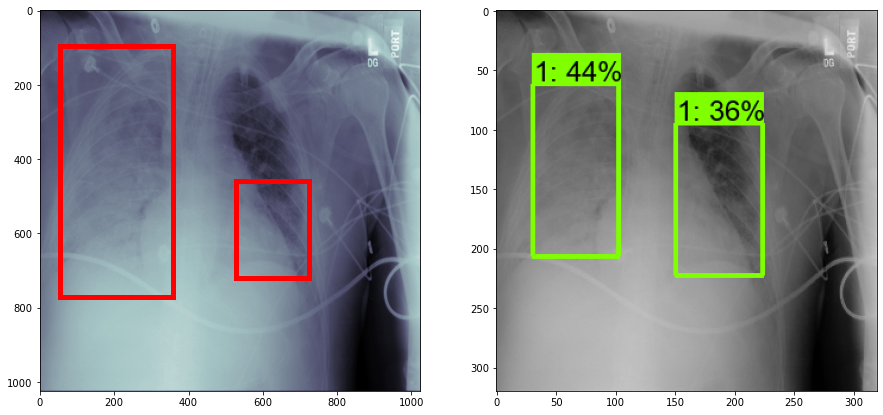

In [23]:
result_check(final_check_images[0])

Running inference for 261341d3-1df2-4cf4-b9a8-b1e02a124900... 

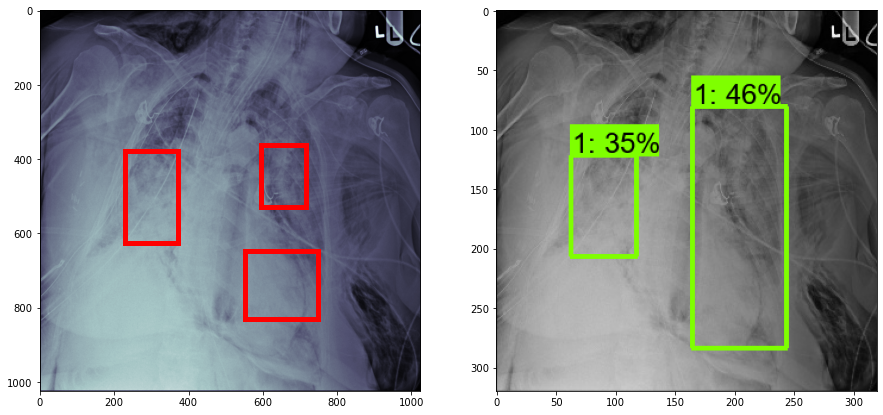

In [24]:
result_check(final_check_images[1])

Running inference for 5a8e51d4-1b33-45b3-8f96-5a4027462cbc... 

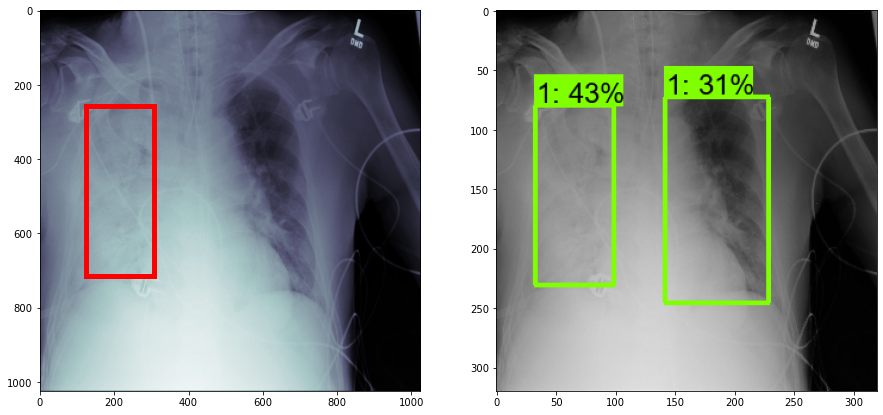

In [25]:
result_check(final_check_images[2])

Running inference for a3558c74-f838-4da4-a8be-ad248ad502cf... 

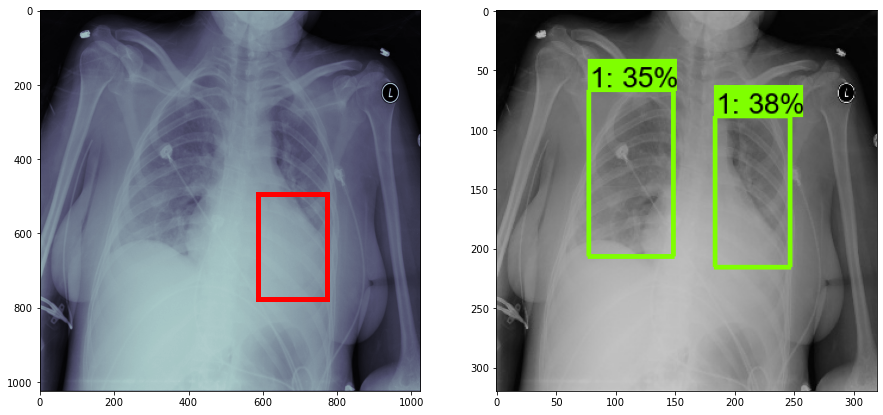

In [26]:
result_check(final_check_images[3])

Running inference for d01efc31-f83e-46dd-a3a1-1eb73f60ddcc... 

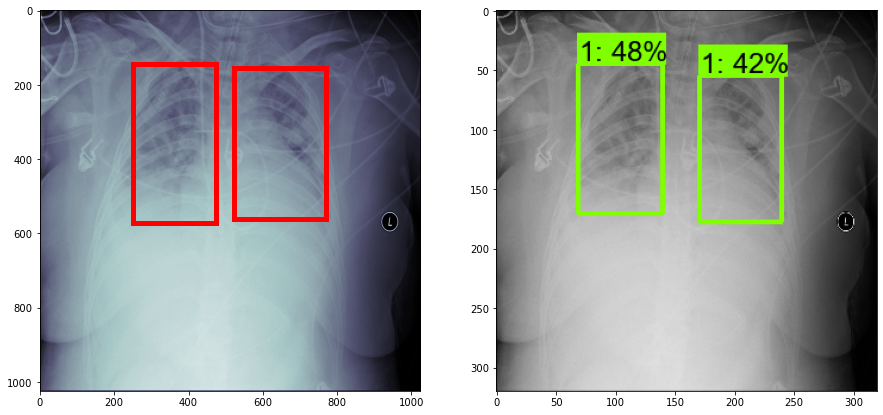

In [27]:
result_check(final_check_images[4])

### Model 2

Model to be used: ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8 <br>
Image size: 640x640

Extracting the downloaded model:

In [67]:
cd C:\Users\Aalap\Documents\Tensorflow\workspace\training_demo\pre-trained-models

C:\Users\Aalap\Documents\Tensorflow\workspace\training_demo\pre-trained-models


In [68]:
import tarfile

with tarfile.open('ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz', 'r:gz') as f:
    f.extractall()

In [69]:
cd C:\Users\Aalap\Documents\Local GL\Capstone

C:\Users\Aalap\Documents\Local GL\Capstone


Loading model:

In [28]:
PATH_TO_MODEL_DIR = r'C:\Users\Aalap\Documents\Tensorflow\workspace\training_demo\exported-models\my_model'

In [29]:
PATH_TO_CFG = PATH_TO_MODEL_DIR + "\pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "\checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tensorflow.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tensorflow.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.5558452606201172 seconds


Loading label data:

In [30]:
PATH_TO_LABELS = r'C:\Users\Aalap\Documents\Tensorflow\workspace\training_demo\annotations\label_map.pbtxt'

In [31]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [32]:
tensorflow.config.run_functions_eagerly(True)

In [33]:
def results_of_training(name):

    print('Running inference for {}... '.format(name), end='')
    
    image_path = 'C:\\Users\\Aalap\\Documents\\Tensorflow\\workspace\\training_demo\\images\\final_check\\' + name + '.jpg'

    image_np = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tensorflow.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tensorflow.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)


    return image_np_with_detections


Running inference for 0851431b-cad7-436f-acb8-06aed97e5339... 

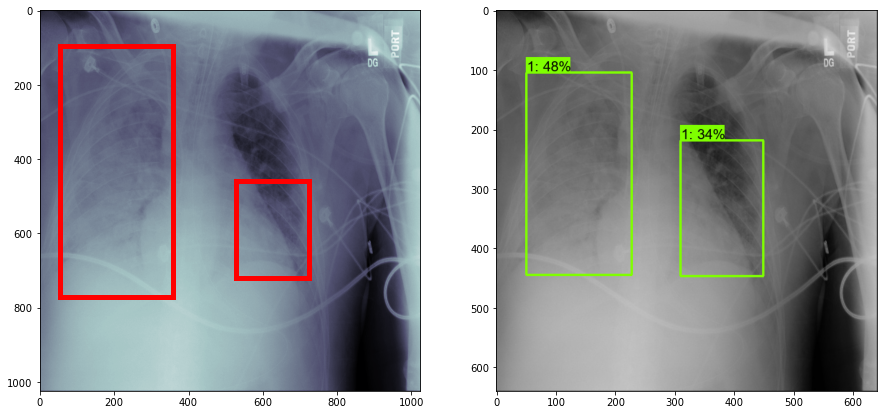

In [34]:
result_check(final_check_images[0])

Running inference for 261341d3-1df2-4cf4-b9a8-b1e02a124900... 

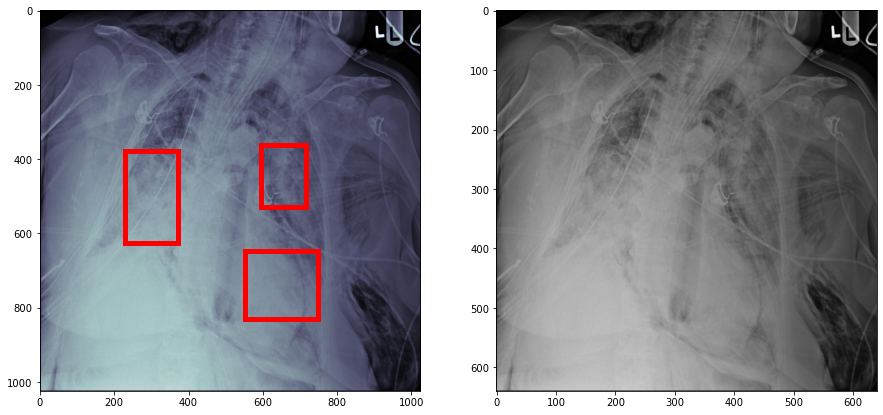

In [35]:
result_check(final_check_images[1])

Running inference for 5a8e51d4-1b33-45b3-8f96-5a4027462cbc... 

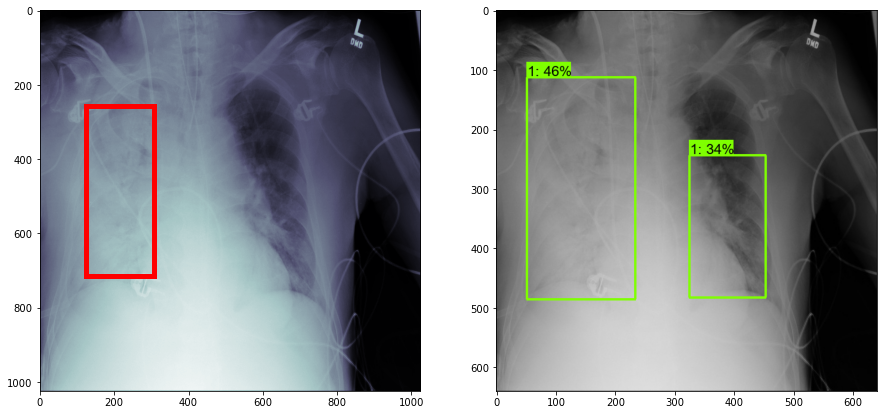

In [36]:
result_check(final_check_images[2])

Running inference for a3558c74-f838-4da4-a8be-ad248ad502cf... 

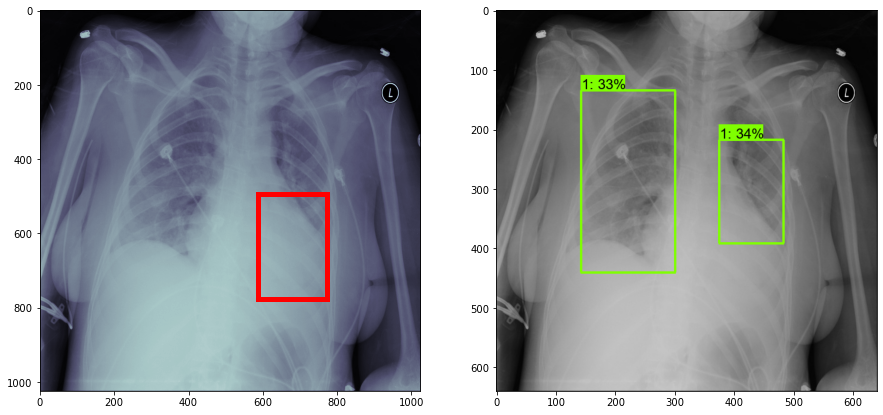

In [37]:
result_check(final_check_images[3])

Running inference for d01efc31-f83e-46dd-a3a1-1eb73f60ddcc... 

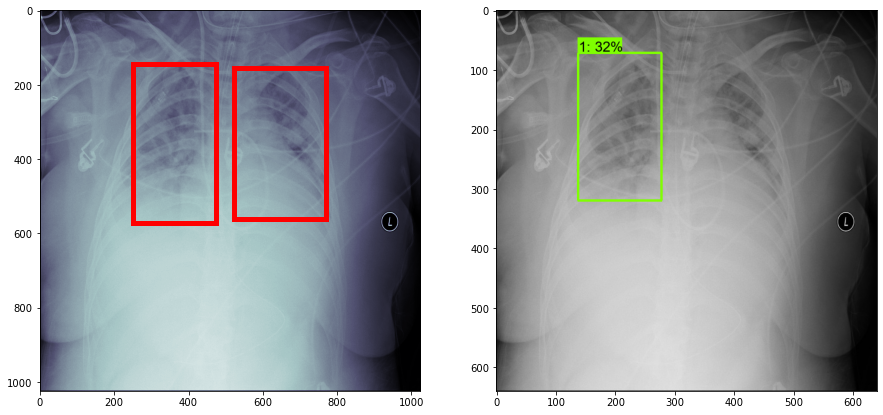

In [38]:
result_check(final_check_images[4])

### Model 3

Model to be used: efficientdet_d0_coco17_tpu-32 <br>
Image size: 512x512

Extracting the downloaded model:

In [14]:
cd C:\Users\Aalap\Documents\Tensorflow3\workspace\training_demo\pre-trained-models

C:\Users\Aalap\Documents\Tensorflow3\workspace\training_demo\pre-trained-models


In [2]:
import tarfile

with tarfile.open('efficientdet_d0_coco17_tpu-32.tar.gz', 'r:gz') as f:
    f.extractall()

In [15]:
cd C:\Users\Aalap\Documents\Local GL\Capstone

C:\Users\Aalap\Documents\Local GL\Capstone


Loading model:

In [16]:
PATH_TO_MODEL_DIR = r'C:\Users\Aalap\Documents\Tensorflow3\workspace\training_demo\exported-models\my_model'

In [17]:
PATH_TO_CFG = PATH_TO_MODEL_DIR + "\pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "\checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tensorflow.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tensorflow.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 4.535654306411743 seconds


Loading label data:

In [18]:
PATH_TO_LABELS = r'C:\Users\Aalap\Documents\Tensorflow3\workspace\training_demo\annotations\label_map.pbtxt'

In [19]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [20]:
tensorflow.config.run_functions_eagerly(True)

In [21]:
def results_of_training(name):

    print('Running inference for {}... '.format(name), end='')
    
    image_path = 'C:\\Users\\Aalap\\Documents\\Tensorflow3\\workspace\\training_demo\\images\\final_check\\' + name + '.jpg'

    image_np = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tensorflow.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tensorflow.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)


    return image_np_with_detections


Running inference for 0851431b-cad7-436f-acb8-06aed97e5339... 

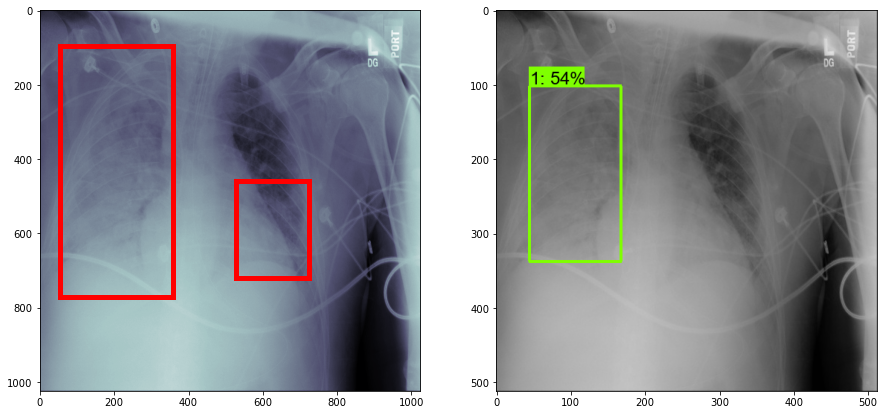

In [24]:
result_check(final_check_images[0])

Running inference for 261341d3-1df2-4cf4-b9a8-b1e02a124900... 

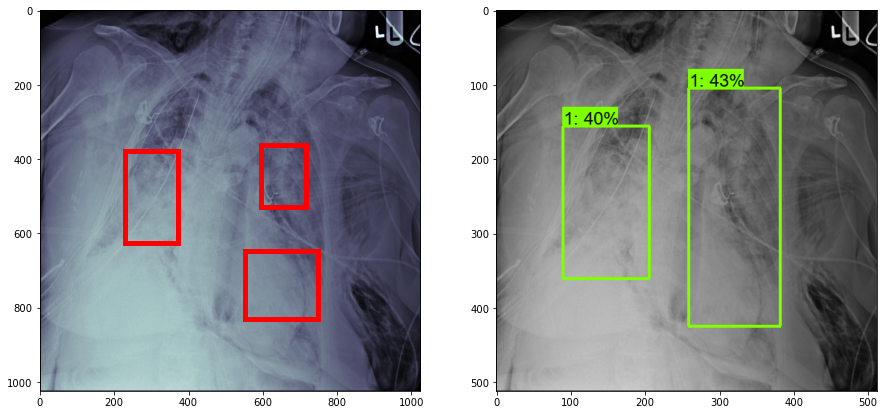

In [25]:
result_check(final_check_images[1])

Running inference for 5a8e51d4-1b33-45b3-8f96-5a4027462cbc... 

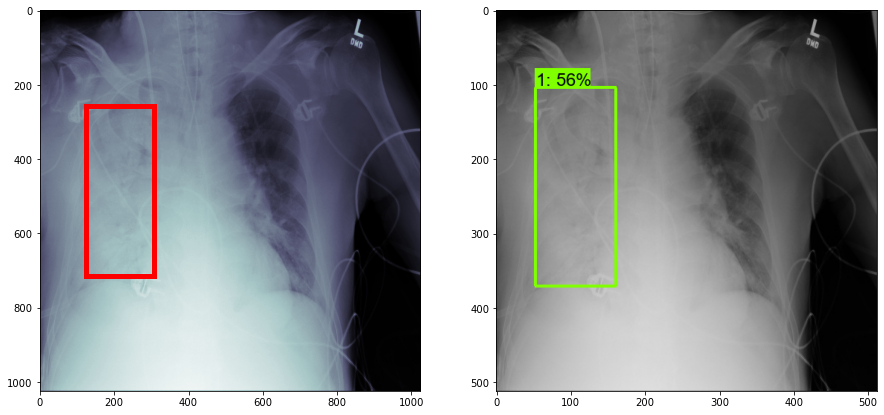

In [26]:
result_check(final_check_images[2])

Running inference for a3558c74-f838-4da4-a8be-ad248ad502cf... 

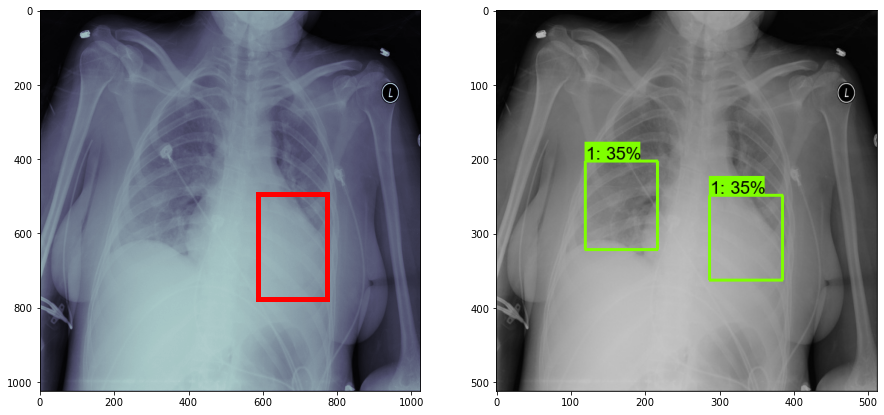

In [27]:
result_check(final_check_images[3])

Running inference for d01efc31-f83e-46dd-a3a1-1eb73f60ddcc... 

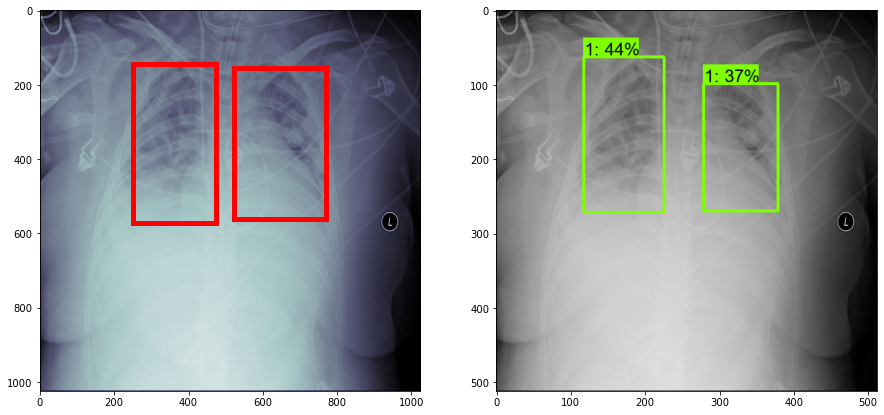

In [28]:
result_check(final_check_images[4])